In [1]:
%cd ..

/home/ubuntu/dev/reid/pepper


In [2]:
# builtin
from collections import Counter, defaultdict
from copy import deepcopy
import os.path as osp
import re
from shutil import copy2 as copy

# third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch

# mm
import mmcv
from mmcv import Config
from mmcv.utils import build_from_cfg

In [3]:
from pepper.datasets import DATASETS

In [4]:
cfg = Config.fromfile("tests/configs/mini_market1501.py")
print(cfg.pretty_text)

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile', to_float32=True),
    dict(type='Resize', size=(256, 128), interpolation='bilinear'),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Collect', keys=['img', 'gt_label']),
    dict(type='FormatBundle')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', size=(256, 128), interpolation='bilinear'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='Collect', keys=['img'], meta_keys=[])
]
data_type = 'ImageDataset'
data_root = 'tests/data/mini_market1501/'
data = dict(
    samples_per_gpu=1,
    workers

In [5]:
dataset = build_from_cfg(cfg.data.train, DATASETS)

In [6]:
print(dataset.ann_file)
print(dataset.data_infos)
print(len(dataset.data_infos))
print(len(dataset))

tests/data/mini_market1501/gtPepper/train.json
[{'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 5, 'img_info': {'filename': '0011_c6s4_002352_01.jpg'}, 'gt_label': array(6)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 3, 'img_info': {'filename': '0035_c4s1_003426_01.jpg'}, 'gt_label': array(2)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 2, 'img_info': {'filename': '0007_c3s3_077344_04.jpg'}, 'gt_label': array(4)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 5, 'img_info': {'filename': '0043_c6s1_004426_01.jpg'}, 'gt_label': array(7)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 1, 'img_info': {'filename': '0007_c2s3_071002_01.jpg'}, 'gt_label': array(4)}, {'img_prefix': 'tests/data/mini_market1501/bounding_box_train', 'camid': 1, 'img_info': {'filename': '0043_c2s1_003626_02.jpg'}, 'gt_label': array(7)}, {'img_prefix': 'tests/data/mini_market15

In [14]:
sample = dataset[1]

dict_keys(['img_metas', 'img', 'gt_label'])


In [15]:
print(sample.keys())
print(type(sample['img']), type(sample['gt_label']))

dict_keys(['img', 'gt_label', 'img_metas'])
<class 'mmcv.parallel.data_container.DataContainer'> <class 'mmcv.parallel.data_container.DataContainer'>


In [16]:
class UnNormalize(object):
    def __init__(self, mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # WARN: this is inplace!!!
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [17]:
mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]

unnorm = UnNormalize(mean=mean, std=std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


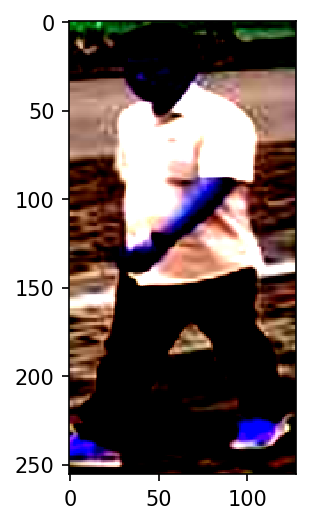

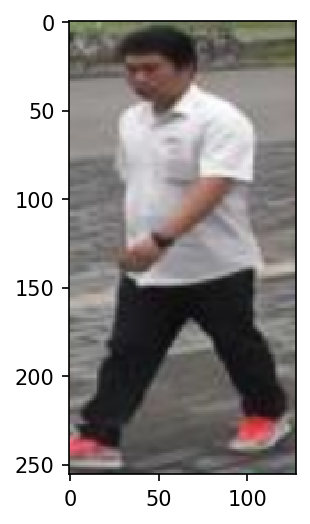

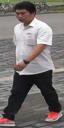

In [18]:
img = sample['img'].data
unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]]
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

pil_img = Image.open(sample['img_metas'].data['filename'])
pil_img.show()

In [19]:
print(sample['gt_label'])

DataContainer(tensor(2))
